In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import  KNeighborsClassifier
import torch
from IPython.display import display_html
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, log_loss, precision_score, recall_score, plot_confusion_matrix
from sklearn.decomposition import PCA
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import gc
import statsmodels.api as sm

%matplotlib inline

In [2]:
# Models to Test: KMeans, XGboost, LogReg, SVM

## Load, shuffle and Split

In [48]:
# Load data
tourney_data = pd.read_csv('tourney_result_2003+.csv')
tourney_data.drop_duplicates(inplace=True)
# split data into training (2003-2015) and test (2016-2019)
tourney_data_train = tourney_data[tourney_data['Season'] <= 2015].drop('Unnamed: 0',axis=1)
tourney_data_test = tourney_data[tourney_data['Season'] >= 2016].drop('Unnamed: 0',axis=1)

In [49]:
# Split Data on both training and test sets
tourney_data_train_clean = tourney_data_train.drop(['Season', 'WTeamID', 'LTeamID','LDivision','WDivision'], axis=1)
tourney_data_test_clean = tourney_data_test.drop(['Season', 'WTeamID', 'LTeamID','LDivision','WDivision'], axis=1)
# Train data
X_train = tourney_data_train_clean.drop('result', axis=1)
y_train = tourney_data_train_clean.result
# Test data
X_test = tourney_data_test_clean.drop('result', axis=1)
y_test = tourney_data_test_clean.result

#X_train, y_train = shuffle(X_train, y_train)

## Model fitting and CV

In [50]:
# For all models, perform PCA and scaling

In [51]:
# Logistic Regression -> l2 so irrelevant data can be reduced to zero
model_pipeline_logreg = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(0.90, svd_solver='full')),
    ('logreg', LogisticRegression(solver='liblinear',penalty='l2'))
])

params = {'logreg__C': np.logspace(start=-5, stop=3, num=9)}

logreg_model = GridSearchCV(model_pipeline_logreg, 
                   params, 
                   cv=5,
                   scoring='neg_log_loss', 
                   refit=True)

logreg_model.fit(X_train, y_train)

print('Best log_loss: {:.4}, with best C: {}'.format(-logreg_model.best_score_, logreg_model.best_params_['logreg__C']))


Best log_loss: 0.5521, with best C: 0.1


In [52]:
# SVM
model_pipeline_svm = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(0.90, svd_solver='full')),
    ('svm', SVC(kernel="rbf", probability=True))
])

# Tuning parameters
kernel = ['rbf'] #Tested ['rbf','sigmoid']
gamma = [0.00001] # Tested np.linspace(1e-5, 5, num=10)
C = [1000.0] # Tested np.logspace(start=-5, stop=3, num=9)
param_grid = {'svm__gamma': gamma,
            'svm__kernel': kernel,
            'svm__C': C }

svm_model = GridSearchCV(model_pipeline_svm,
                    cv=5, 
                    param_grid=param_grid, 
                    scoring='neg_log_loss', 
                    refit=True)

svm_model.fit(X_train, y_train)

print('Best log_loss: {:.4}, with best gamma: {} and kernel: {} and C: {}'.format(-svm_model.best_score_, 
                                                                       svm_model.best_params_['svm__gamma'],
                                                                        svm_model.best_params_['svm__kernel'],
                                                                        svm_model.best_params_['svm__C']))

Best log_loss: 0.5538, with best gamma: 1e-05 and kernel: rbf and C: 1000.0


In [53]:
# KMeans
# Logistic Regression -> l2 so irrelevant data can be 
model_pipeline_knn = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(0.90, svd_solver='full')),
    ('knn', KNeighborsClassifier())
])
params = {
         'knn__n_neighbors': [9] # Tested np.array(range(1,30))
}

knn_model = GridSearchCV(model_pipeline_knn, 
                   params,
                   cv=5, 
                   scoring='neg_log_loss', 
                   refit=True)

knn_model.fit(X_train, y_train)

print('Best log_loss: {:.4}, with best K: {}'.format(-knn_model.best_score_, 
                                                     knn_model.best_params_['knn__n_neighbors']))

Best log_loss: 0.3485, with best K: 9


In [54]:
# XGBoost
# https://www.kaggle.com/khoongweihao/ncaam2020-xgboost-lightgbm-k-fold-baseline
model_pipeline_xgb = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(0.90, svd_solver='full')),
    ('xgb', XGBClassifier())
])

parameters = {'xgb__nthread':[4], 
              #when use hyperthread, xgboost may become slower
              'xgb__objective':['binary:logistic'],
              'xgb__learning_rate': [0.03], # Tested [0.003,0.03,0.3]
              # As it decreases, we the weight of each individual tree turns down
              'xgb__max_depth': [6], #Tested [6,7,8]
              'xgb__reg_lambda': [6], # Regularization parameters Tested [2,4,6]
              'xgb__gamma':[1], # Min threshold gain for tree pruning, tested [0,3,6], 
              #0 was best but maybe over fit so we try 1
              'xgb__min_child_weight': [1], # Deault
              'xgb__silent': [1],
              'xgb__subsample': [0.8],
              'xgb__colsample_bytree': [0.7],
              'xgb__n_estimators': [1000], #number of trees, change it to 1000 for better results
              'xgb__missing':[-999],
              'xgb__seed': [1337],
             }


xgboost_model = GridSearchCV(model_pipeline_xgb, 
                   parameters, 
                   n_jobs=10, 
                   cv=5, 
                   scoring='neg_log_loss',
                   verbose=1, 
                   refit=True)
xgboost_model.fit(X_train, y_train)
print(xgboost_model.best_score_)
print(xgboost_model.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.6s finished


-0.2400547381781691
{'xgb__colsample_bytree': 0.7, 'xgb__gamma': 1, 'xgb__learning_rate': 0.03, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__missing': -999, 'xgb__n_estimators': 1000, 'xgb__nthread': 4, 'xgb__objective': 'binary:logistic', 'xgb__reg_lambda': 6, 'xgb__seed': 1337, 'xgb__silent': 1, 'xgb__subsample': 0.8}


In [55]:
# Script to send a mac notification to me when the models are done training!
import os
os.system("osascript -e 'display notification \" Your best score is "+str(xgboost_model.best_score_)+". Open Jupyter notebook to check your score. \" with title \"Model is done Fitting\" sound name \"Bell\"'")

0

## Compare Models
Compare the best of: SVM, Logistic Regression, K-means, XGBoost

In [56]:
# Get test results

In [57]:
# Get test predictions For Regularized Logistic Regression
y_pred_logreg = logreg_model.predict_proba(X_test)
log_loss(y_test, y_pred_logreg)

0.57002025439284

In [58]:
# Get test predictions for SVM
y_pred_svm = svm_model.predict_proba(X_test)
log_loss(y_test, y_pred_svm)

0.5681365214257659

In [59]:
# Get test predictions for KNN
y_pred_knn = knn_model.predict_proba(X_test)
log_loss(y_test, y_pred_knn)

0.3225090297239162

In [60]:
# Get test predictions for XGBoost
y_pred_knn = xgboost_model.predict_proba(X_test,)
log_loss(y_test, y_pred_knn)

0.23794785012802067

In [61]:
# Compare test losses
results = {'Model':['Logistic Regression',
                    'SVM',
                    'KNN',
                    'XGBoost'],
            'Hypertuned Parameters':[logreg_model.best_params_,
                                svm_model.best_params_,
                                knn_model.best_params_,
                                xgboost_model.best_params_],
            'Log Loss':[log_loss(y_test, logreg_model.predict_proba(X_test)),
                        log_loss(y_test, svm_model.predict_proba(X_test)),
                        log_loss(y_test, knn_model.predict_proba(X_test)),
                        log_loss(y_test, xgboost_model.predict_proba(X_test))],
            'Accuracy':[accuracy_score(y_test, logreg_model.predict(X_test)),
                        accuracy_score(y_test, svm_model.predict(X_test)),
                        accuracy_score(y_test, knn_model.predict(X_test)),
                        accuracy_score(y_test, xgboost_model.predict(X_test))],
            'f1_score':[f1_score(y_test, logreg_model.predict(X_test)),
                        f1_score(y_test, svm_model.predict(X_test)),
                        f1_score(y_test, knn_model.predict(X_test)),
                        f1_score(y_test, xgboost_model.predict(X_test))]}

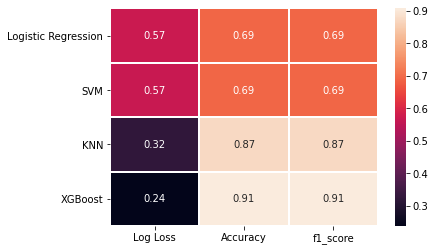

In [62]:
# Build table
# Visualize the lossess
results_table = pd.DataFrame(results)
sns.heatmap(results_table.drop(['Hypertuned Parameters','Model'],axis=1), 
            annot=True,
           yticklabels=['Logistic Regression',
                    'SVM',
                    'KNN',
                    'XGBoost'],
           linewidths=1)

In [63]:
results_table

,Model,Hypertuned Parameters,Log Loss,Accuracy,f1_score
0,Logistic Regression,{'logreg__C': 0.1},0.570020,0.690299,0.690299
1,SVM,"{'svm__C': 1000.0, 'svm__gamma': 1e-05, 'svm__...",0.568137,0.690299,0.690299
2,KNN,{'knn__n_neighbors': 9},0.322509,0.873134,0.873134
3,XGBoost,"{'xgb__colsample_bytree': 0.7, 'xgb__gamma': 1...",0.237948,0.906716,0.906367


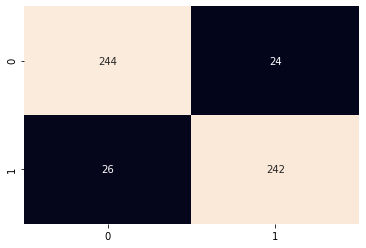

In [64]:
fig, ax = plt.subplots()
confusion_matrix2 = sns.heatmap(confusion_matrix(y_test, xgboost_model.predict(X_test)),annot=True,cbar=False,fmt='.4g')
confusion_matrix2

## Compare to Betting odds

Future Work

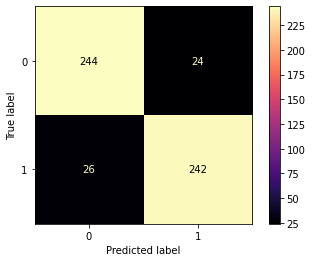

In [65]:
confusion = plot_confusion_matrix(y_true=y_test, estimator=xgboost_model, X=X_test, cmap='magma',values_format='.5g')

In [47]:
confusion.figure_.savefig('confusion.png',transparent=True)
#plt.save_fig('confusion.png')